# Modeling with seasonality
modeling time series assumes stationarity and therefore the removal of seasonal patterns. This is performed in the main notebook, but here is an experiment in modeling the raw data without the seasonal trends removed

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
#opening the dataframe that was prepared in separate "Data Prep" notebook in this repo (see above for link)
main_df = pd.read_csv('data/main_df.csv')

In [174]:
# preparing the train/test split for logistic regression
X = main_df.drop(columns=['Pollen Total', 'pollen_weighted', 'super_high', 'very_high', 'high'])
y= main_df['high']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=85)

In [175]:
ss_s = StandardScaler()

X_train_scaled = ss_s.fit_transform(X_train)
X_test_scaled = ss_s.transform(X_test)

### Dummy Classifier
A dummy classifier that always returns the majority class was chosen as a baseline model

In [56]:
#showing the class breakdown of our data in percentage a 1.0 indicates a 'high' pollen data
y_test.value_counts(normalize=True)

1.0    0.512158
0.0    0.487842
Name: high, dtype: float64

In [57]:
baseline_model_s = DummyClassifier(strategy='most_frequent')
baseline_model_s.fit(X_train_scaled, y_train)
print('Accuracy:', baseline_model_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, baseline_model_s.predict(X_test_scaled)))

Accuracy: 0.5121580547112462 Precision: 0.5121580547112462


51% of the days in our test data are `high` pollen days so that is the best the dummy model can do. We next try logistic regression:

## First Logistic Regression for data with seasonality

In [62]:
lr1_s = LogisticRegression(random_state=85)
lr1_s.fit(X_train_scaled, y_train)
print('Accuracy:', lr1_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, lr1_s.predict(X_test_scaled)))

Accuracy: 0.5759878419452887 Precision: 0.5697115384615384


This outperforms the baseline, barely. There is high multicolinearity in this data so it makes more sense to use a decision tree or random forest classifier

## First Decision Tree Classifier with seasonality

In [202]:
dt1_s = DecisionTreeClassifier(random_state=85)
dt1_s.fit(X_train_scaled, y_train)
print('Accuracy:', dt1_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, dt1_s.predict(X_test_scaled)))

Accuracy: 0.5759878419452887 Precision: 0.5814606741573034


This decision tree matches the logistic regression in accuracy and onlt slightly outperforms in its precision. The next step is to see if tweaking paramaters improves it even more 
## Second Desicion Tree with Seaonality
To start we'll tweak one parameter `max_depth` to see if that improves it at all

In [213]:
dt2_s = DecisionTreeClassifier(random_state=85, max_depth=6)
dt2_s.fit(X_train_scaled, y_train)
print('Accuracy:', dt2_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, dt2_s.predict(X_test_scaled)))

Accuracy: 0.6367781155015197 Precision: 0.6324324324324324


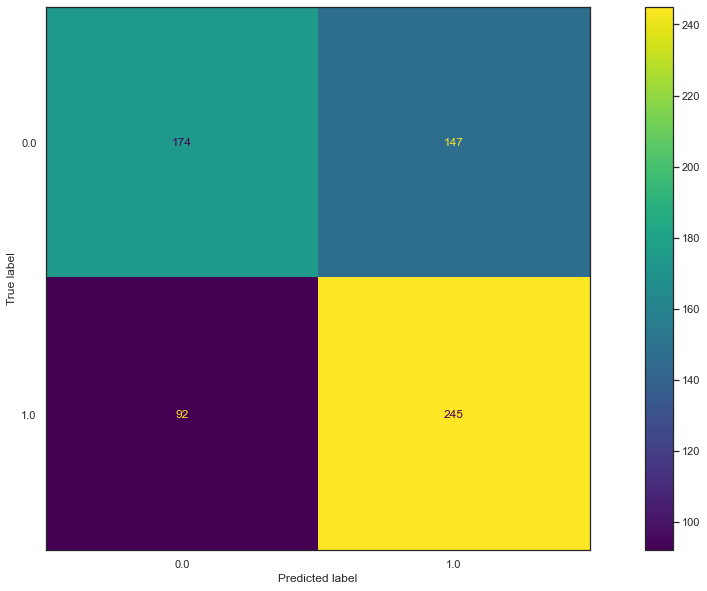

In [212]:
plot_confusion_matrix(dt2_s, X_test_scaled, y_test)

Modest improvement in both metrics here so it's followed up with a grid search of paramaters to see if it can produce even more accurate results
### Grid Search for decision tree parameters

In [418]:
#The parameters to be iterated over in decision tree models
param_grid_dt_s = {
      'criterion':['gini', 'entropy'], 
      'max_depth':[2, 4, 10, 20, None],
      'min_samples_leaf':[1,  3, 4, 5, 6, 10]
 }
    
gridsearch_dt_s= GridSearchCV(estimator=DecisionTreeClassifier(random_state=85),
                  param_grid=param_grid_dt_s,
                  cv=10,
                  )

grid_results_dt_s = gridsearch_dt_s.fit(X_train_scaled, y_train)

In [419]:
#shows the parameters discovered by the grid search to optimize the model
grid_results_dt_s.best_params_

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1}

These parameters are applied to a new model
## Grid Search Decision Tree with Seasonality

In [422]:
grid_dt_s = DecisionTreeClassifier(random_state=85, criterion='entropy', max_depth=4, min_samples_leaf=1)

grid_dt_s.fit(X_train_scaled, y_train)
print('Accuracy:', grid_dt_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, grid_dt_s.predict(X_test_scaled)))

Accuracy: 0.6352583586626139 Precision: 0.6094808126410836


model performance:
grid search does not always produce the best results, but can offer a hint at where to make changes which will happen for the final Decision Tree model
## Final Decision Tree Model with Seaonality


In [432]:
final_dt_s = DecisionTreeClassifier(random_state=85, max_depth=6, min_samples_leaf=4 )

final_dt_s.fit(X_train_scaled, y_train)
print('Accuracy:', final_dt_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, final_dt_s.predict(X_test_scaled)))

Accuracy: 0.6519756838905775 Precision: 0.6534090909090909


 This has the best performace so far on both precision and accuracy, 65.2% and 65.3% respectively. Given the success of a single decision tree, the next models will be random forest classifiers
## First Random Forest Classifer with Seasonality

In [214]:
rfc1_s = RandomForestClassifier(random_state=85)

rfc1_s.fit(X_train_scaled, y_train)
print('Accuracy:', rfc1_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, rfc1_s.predict(X_test_scaled)))

Accuracy: 0.6413373860182371 Precision: 0.6383561643835617


This first Random Forest already outperforms our early Decision Trees on both accuracy and precision. Again the next step is to try tweaking parameters starting with `max_depth` as before 
## Second Random Forest Classifier with Seaonality

In [225]:
rfc2_s = RandomForestClassifier(random_state=85, max_depth=5)

rfc2_s.fit(X_train_scaled, y_train)
print('Accuracy:', rfc2_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, rfc2_s.predict(X_test_scaled)))

Accuracy: 0.6534954407294833 Precision: 0.639386189258312


Again improvement is seen, so it makes sense to proceed as before with a grid search
### Grid Search for Random Forest Classifier


In [466]:
#The parameters to be iterated over in decision tree models
param_grid_rfc_s = {
      'n_estimators':[50, 100, 500],
      'criterion':['gini', 'entropy'], 
      'max_depth':[2, 4, 10, 20, None],
      'min_samples_leaf':[1, 3, 4, 5, 6, 10]
 }
    
gridsearch_rfc_s= GridSearchCV(estimator=RandomForestClassifier(random_state=85),
                  param_grid=param_grid_rfc_s,
                  cv=10,
                  )

grid_results_rfc_s = gridsearch_rfc_s.fit(X_train_scaled, y_train)

In [468]:
#returns best parameters for the Random Forest
grid_results_rfc_s.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 3,
 'n_estimators': 500}

Taking these parameters identified by the grid search to use on our next Random Forest
## Grid Search Random Forest Classifier with Seasonality

In [470]:
grid_rfc_s = RandomForestClassifier(random_state=85, max_depth=10, 
                                    criterion='entropy', min_samples_leaf=3, n_estimators=500)

grid_rfc_s.fit(X_train_scaled, y_train)
print('Accuracy:', grid_rfc_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, grid_rfc_s.predict(X_test_scaled)))

Accuracy: 0.6519756838905775 Precision: 0.6459459459459459


Again we see if tweaking these parameters manually can improve the model further
## Final Random Forest Classifier with Seasonality

In [489]:
final_rfc_s = RandomForestClassifier(random_state=85, max_depth=6, min_samples_leaf=3, criterion='gini', n_estimators=200)

final_rfc_s.fit(X_train_scaled, y_train)
print('Accuracy:', final_rfc_s.score(X_test_scaled, y_test), 
      'Precision:', precision_score(y_test, final_rfc_s.predict(X_test_scaled)))

Accuracy: 0.6595744680851063 Precision: 0.6475195822454308


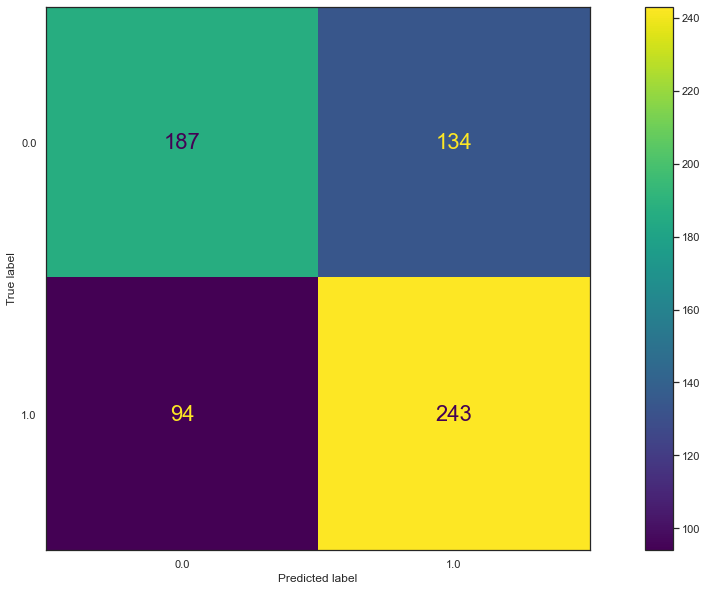

In [235]:
#confusion matrix for final RFC 
plot_confusion_matrix(final_rfc_s, X_test_scaled, y_test);

The best classification model for seasonal pollen is the Random Forest Classifier above with 66% accuracy and 65% precision. Again all these data fluctuate seasonally, so we next try to tackle the question of, do these climate variables still have any predictive power when seasonality is taken out. Given the high seasonal regularity of pollen counts and the climate variables,  a K nearest neighbors model should be considered 

## K-Nearest Neighbors Model

In [570]:
knn = KNeighborsClassifier(n_neighbors=13)

knn.fit(X_train_scaled, y_train)
print('Accuracy:', knn.score(X_test_scaled, y_test), ', Precision:', precision_score(y_test, knn.predict(X_test_scaled)))

Accuracy: 0.6595744680851063 , Precision: 0.6522911051212938


Having manually tweaked parameters, it was discovered that 13 nearest neighbors provides the best scores for this model. This matches the Random Forest for highest accuracy at 66%, but improves the precision score by about 0.5% for 65.2%. while The final Decision Tree has a slightly higher precision score of 65.3%, The relatively higher accuracy and precision likely makes a this the best classification model for these data given the metrics.

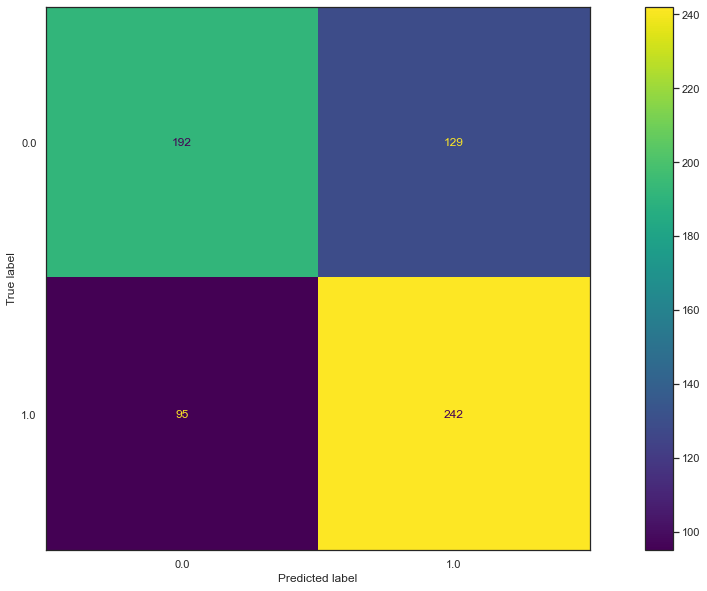

In [574]:
plot_confusion_matrix(knn, X_test_scaled, y_test);


# 5b) Modeling Without Seasonality
in order to separate the seasonal component from the data, we try seasonal decomposition and isolate the residuals

### Seasonal Decomposition
given the high seasonlity of both target and variables, the first step is to remove that dependence from the data.

In [455]:
#uses stats models' seasonal_decompose to break the data into its trend and seasonal components
decomp_pollen = seasonal_decompose(main_df['pollen_weighted'].resample('D').mean(), extrapolate_trend='freq', period=365)

''

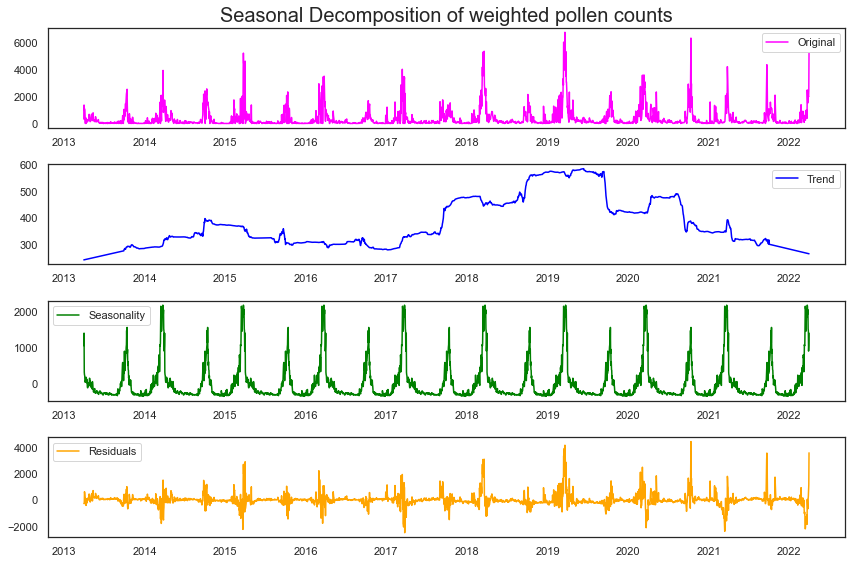

In [580]:
#isolating the decomposed elements
trend = decomp_pollen.trend
seasonal = decomp_pollen.seasonal
residual = decomp_pollen.resid

# plotting the decomposition
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(main_df['pollen_weighted'], label='Original', color='magenta')
plt.title('Seasonal Decomposition of weighted pollen counts', size=20)
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='orange')
plt.legend(loc='best')
plt.tight_layout()
;

The above shows the break down of our decomposed `pollen_weighted` data. To the eye it still looks as if there are seasonal fluctuations in the residuals, but this worked better than differencing (Appendix)

The point in this section is to remove the seasonal component from all elements in the dataframe. This is performed in the main notebook.